# Key Component Investigation

In order to achieve my initial goal of recreating the model from the reference paper, there are a number of key components that require further investigation. Many of these components are both unknown to me but are also out of the mainstream, so more digging and research is required as compared to something more standard. The idea is that by the end of this notebook the reader and I will have a solid understanding of everything that I need to build the model. From there, it is simply putting all the pieces together in the correct order.

Before we begin I will point out one software package that will be aiding me throuhout, namely [Open3D](http://www.open3d.org/docs/release/index.html). This is an open source python package for 3D data processing, and it should be extremely helpful in visualization and data manipulation. We will discuss more of the specifics below as they come up.

## Datasets

This is a key component to any deep learning project and mine is no exception. In any dataset that could be used in this project we are specifically looking at 3D LiDAR point cloud data. Essentially this just boils down to 3D (i.e. x,y,z) coordinates in space obtained from the LiDAR sensors. In the reference paper they use the Waymo Open dataset, most likely because it is large and affiliated with Google, as are the researchers. However, there are a number of other datasets that could be viable alternatives. The main motivation for using a different dataset would be in its size and usability. We will investigate a number of these datasets to determine which will be the easiest to work with, but still powerful enough for effective learning. To visualize the point clouds we are using the Open3D software discussed above.

### Waymo Open

This dataset from the Waymo self-driving company has 1000 diverse scenes with LiDAR and 2D camera data. There are about 200 frames in each scene with a frame rate of 100ms. Within each LiDAR frame there are labels and bounding boxes for vehicles, pedestrians, cyclists, and signs. Each scene also has a number of other associated metadata like coordinate frames, calibrations, etc.

The entire dataset is 2TB which is... scary, to say the least. It is broken into 32 training chunks and 8 validation chunks of about 25GB. I have downloaded one of the chunks (which can be done [here](https://waymo.com/open/download/)), and placed it in the *waymo-training-0000* folder. Waymo provides a [GitHub repository](https://github.com/waymo-research/waymo-open-dataset) with software tools for working with their data. They also offer a [CoLab tutorial](https://colab.research.google.com/github/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb) which I have used as a starting point. Also note that I have not included the data in this repository as it is too large.

In [1]:
'''
Loading our required packages
'''
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

import open3d as o3d

In [2]:
'''
Importing the dataset and extracting a single frame
'''
path = 'waymo-training-0000/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord'

dataset = tf.data.TFRecordDataset(path, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))

In [3]:
print(frame.context.stats)

laser_object_counts {
  type: TYPE_VEHICLE
  count: 20
}
laser_object_counts {
  type: TYPE_SIGN
  count: 5
}
time_of_day: "Day"
location: "location_phx"
weather: "sunny"
camera_object_counts {
  type: TYPE_VEHICLE
  count: 31
}



We can see a number of statistics associated with our extracted frame printed above, and recall that this is one frame of one scene. Specifically, there were 20 vehicles and 5 signs detected by the LiDAR. Accessing the *frame.context* will also give a number of other data besides the statistics seen above, but most of it is callibration.

Below we extract the point cloud data from our single frame. We note that there are actually two sets of point clouds from the two strongest returns of the LiDAR, but for now we only examine the first. We can use both point clouds and combine them for a denser sample and thus more accurate voxel averages.

In [5]:
'''
Extract point cloud data
'''
(range_images, camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

points, _ = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)

#3D points in vehicle frame
points_all = np.concatenate(points, axis=0)
print(points_all)
print(points_all.shape)

[[-4.5754883e+01  2.7728516e+01  4.2820435e+00]
 [-4.5678711e+01  2.7833008e+01  4.2821655e+00]
 [-4.5059570e+01  2.7758789e+01  4.2612915e+00]
 ...
 [-1.1676830e+00 -7.2042100e-02 -6.3550174e-03]
 [-1.1092112e+00 -3.8282093e-02  2.4845839e-02]
 [-1.1944568e+00 -4.0513471e-02 -2.1737218e-03]]
(161970, 3)


The point cloud data as extracted from the dataset directly is just an $N\times 3$ matrix where $N=161,970$ is the number of x, y, z points. However, we need to convert this into the Open3D format to use their visualization.

In [7]:
'''
Convert data to Open3D point cloud
'''
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_all)
# pcd.paint_uniform_color(np.array([0.3,0.5,0.9]));

We have our point cloud data ready to go, but we still need the data annotations.

In [8]:
print('Total object annotations: {}\n'.format(len(frame.laser_labels)))
print(frame.laser_labels[0])

Total object annotations: 25

box {
  center_x: -24.892634233954595
  center_y: 37.00759286435823
  center_z: 0.7652850658038233
  width: 0.5771762910042088
  length: 0.09371839054968478
  height: 0.8100000000000023
  heading: -1.7668764026490678
}
metadata {
  speed_x: 0.024620707192504532
  speed_y: -0.13428112680120208
  accel_x: 0.013816282930839013
  accel_y: -0.03797582566500794
}
type: TYPE_SIGN
id: "-oh22MsWr26_sfMjVwsbTw"
num_lidar_points_in_box: 15



In the output above we see the first frame annotation of 25 total. There is bounding box described by a number of attributes, velocity and acceleration data for the car (which we note is in the global coordinate frame), and a classification label which in this case is a sign.

Next, we need to convert these bounding boxes into a form that we can use in our visualization.

In [18]:
'''
Convert bounding box data to Open3D form
'''
data = [pcd]

for i in range(len(frame.laser_labels)):
    box = frame.laser_labels[i].box
    
    
    bb = o3d.geometry.OrientedBoundingBox()
    bb.center = np.array([[box.center_x], [box.center_y], [box.center_z]])
    bb.extent = np.array([[box.length], [box.width], [box.height]])

#     bb.color = (1,0,0)

    data.append(bb)

In [20]:
'''
Visualize our scene
'''
o3d.visualization.draw_geometries(data)

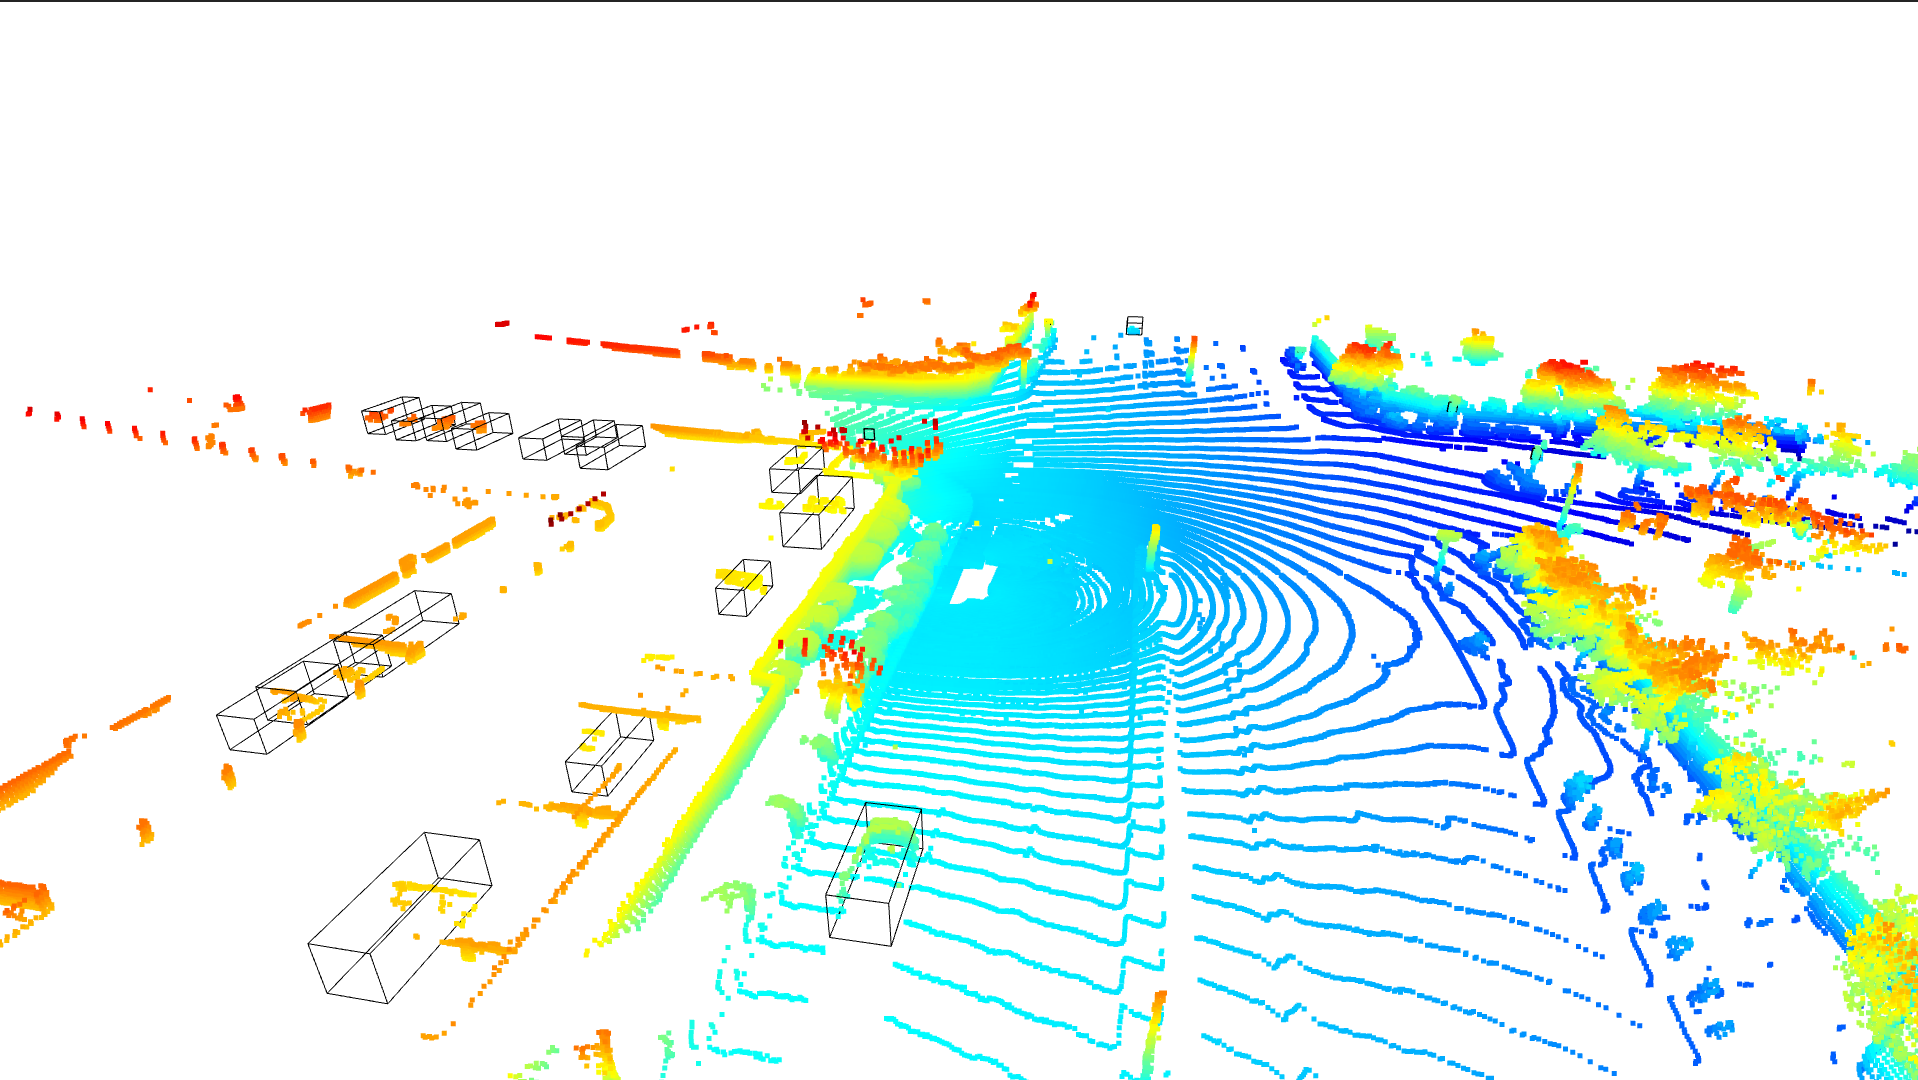

In [23]:
from IPython.display import display, Image
display(Image('assets/viz1.png'))

In running the visualization above one may note that some of the bounding boxes are not oriented correctly. This is because we haven't yet taken into account the *heading* attribute provided in the bounding box. As described by Waymo this heading is the angle from $[-\pi,\pi]$ needed to align the object positive x-axis with the vehicle's forward axis. The boxes have zero pitch and zero roll (i.e no rotation around the x or y axes). Open3D requires this orientation information to be in the form of $3\times 3$ rotation matrix.

We want to rotate about the z-axis so our rotation matrix will be of the following form where $\theta$ is the heading value:

$$
R(\theta) =
\begin{bmatrix}
\cos(\theta) &-\sin(\theta) &0\\
\sin(\theta) &\cos(\theta) &0\\
0 &0 &1
\end{bmatrix}
$$

Lets apply this to our bounding boxes.

In [24]:
'''
Apply rotation matrix to bounding boxes
'''
for i in range(1, len(data)):
    theta = frame.laser_labels[i-1].box.heading
    
    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])
    
    data[i] = data[i].rotate(R)

In [25]:
o3d.visualization.draw_geometries(data)

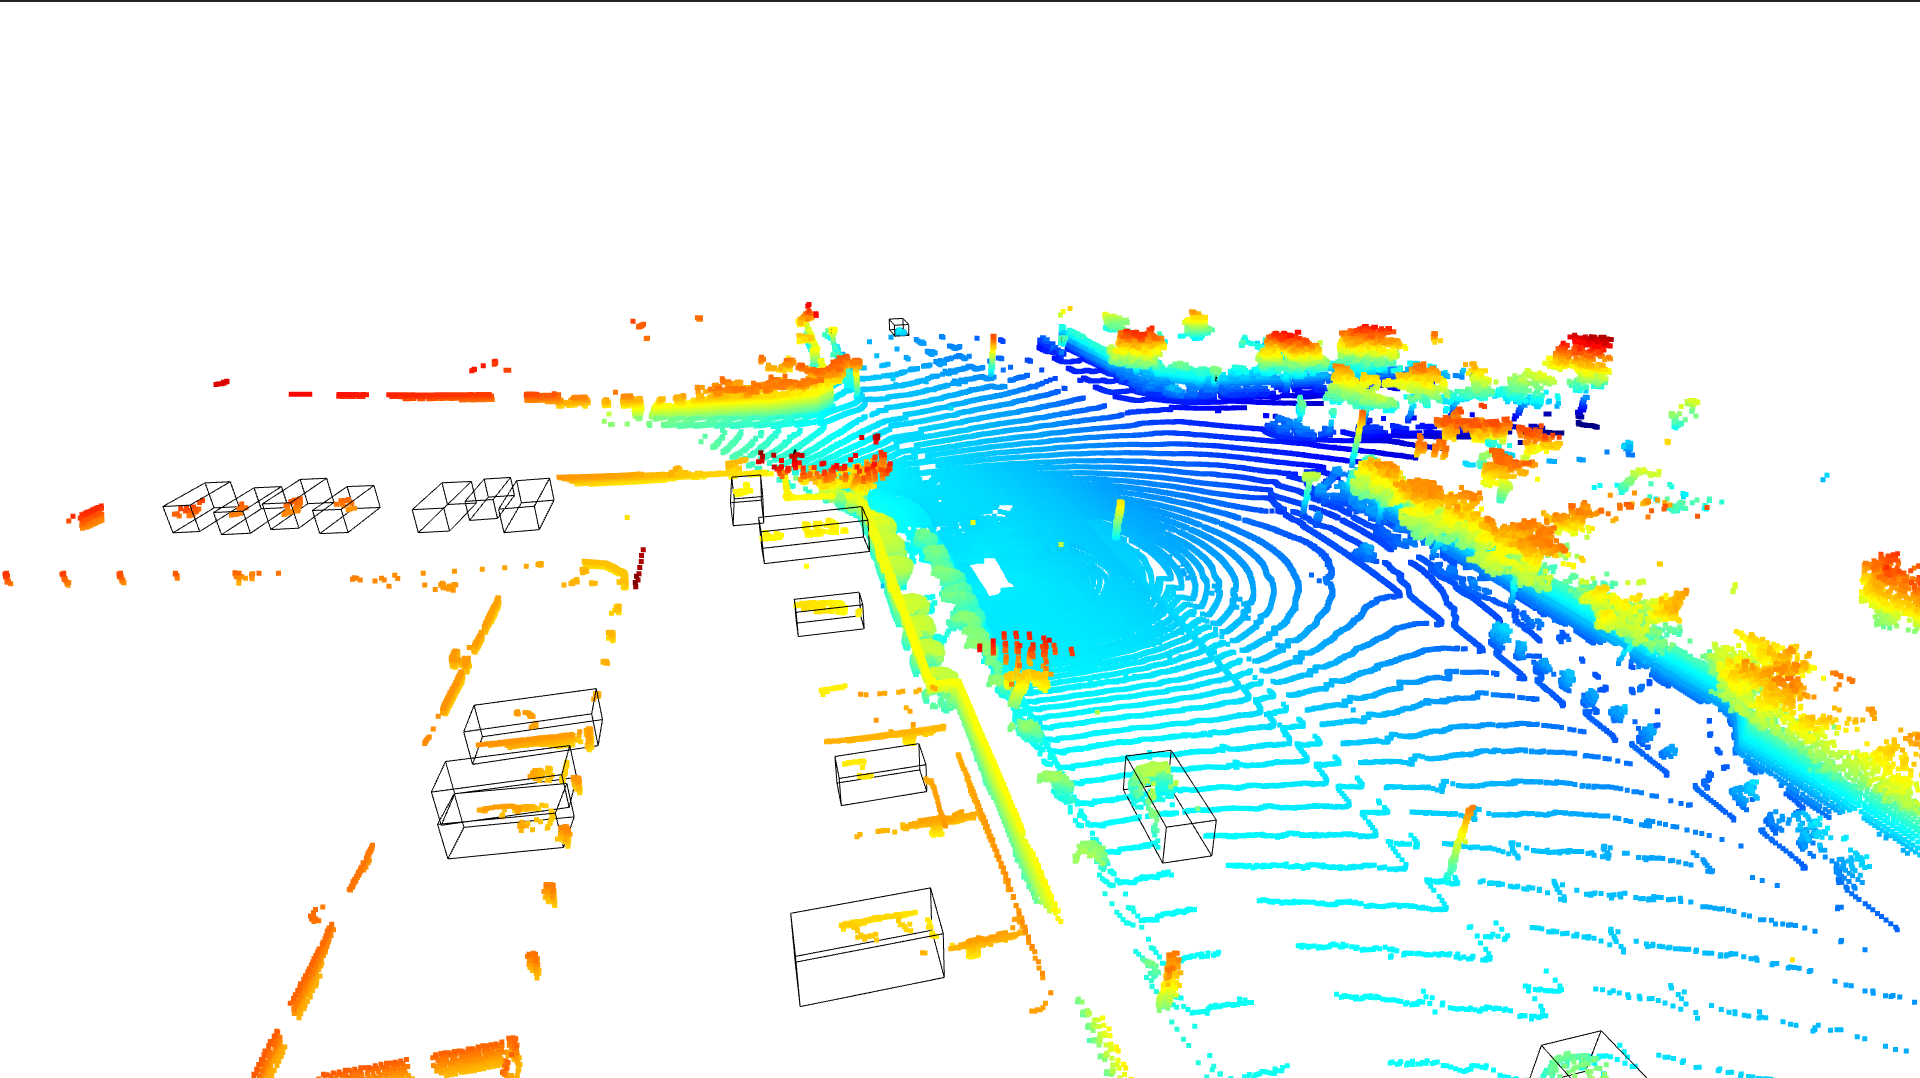

In [27]:
display(Image('assets/viz2.png'))

Now that looks a little better.

### nuScenes

This dataset is similar to Waymo Open and comes from another self-driving company Motional. There are 1000 scenes of 20 second length with 2D camera and 3D LiDAR data. In additon to this there is additional data like radar that is inconsequential to this project. Bounding boxes and labels are included for 23 different classes, and we will note that there is only one top mounted LiDAR as opposed to the five in Waymo Open. Lastly, nuScenes also provides a LiDAR segementation adaptation of the dataset where every point in the point cloud has a label. It is not immediately clear how this might be helpful as it is a slightly different task than what I have set for myself, but it is worth keeping in mind.

I won't investigate this dataset in detail yet as it is very similar to Waymo Open, but I will potentially revisit it in the future. One feature of the nuScenes dataset is that it allows one to download specific sensor data only (i.e. only LiDAR). This could be hugely beneficial as it would significantly reduce the size of the dataset.

### Open3D Supported

Open3D supports a number of utilities specifically aimed at deep learning in TensorFlow and PyTorch. Included in this is targeted support for a number of publicly available datasets, as well as general support for working with datasets. Many of the supported datasets are not applicable to this work as they are not scene based (i.e. they are static single frames) -- although they may be useful for pre-training. 

## Voxelization

Voxels are essentially the 3D equivalent of pixels, and the process of voxelization takes a 3D point cloud and constructs a regular grid of voxels. Each voxel may or may not contain points from the cloud which is where sparse convolutions will come in later. Open3D provides support for voxel downsampling of point clouds where voxels that contain multiple points average them. This is precisely what the reference paper is doing, so this tool should work perfectly for our uses.

We can see this process in action below using the point cloud from the Waymo Open dataset. We set the voxel size to 1 to emphasis the effect, but we note that the reference paper uses a size of 0.2.

In [32]:
vox = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=1)
for v in vox.get_voxels():
    v.color = (0.294, 0.815, 0.886)

data[0] = vox
o3d.visualization.draw_geometries(data)

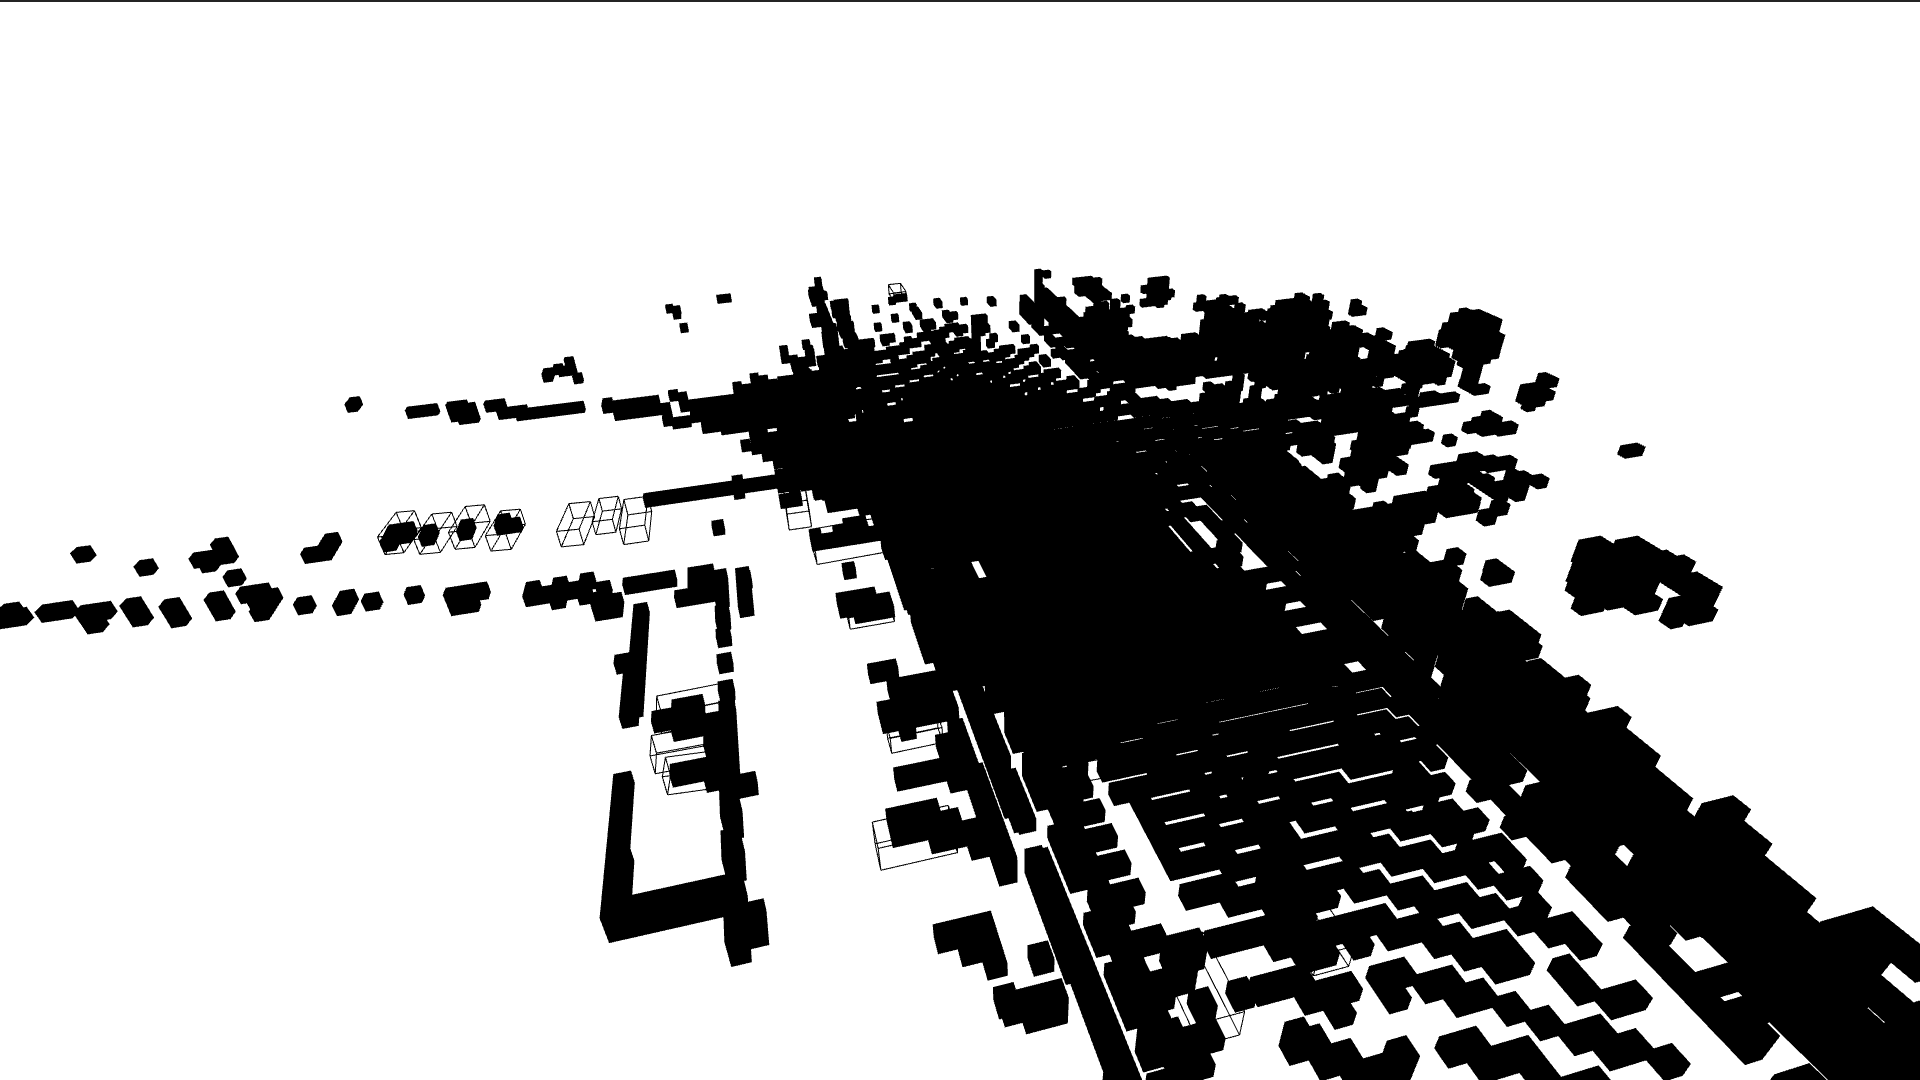

In [33]:
display(Image('assets/vox1.png'))

It is clear from the visualization above that the voxel grid is quite sparse, but we want to be sure of this.

In [44]:
print('Total number of points: {}\n'.format(points_all.shape[0]))

minb = vox.get_min_bound()
maxb = vox.get_max_bound()
print('Voxel dimension bounds:\n{}\n{}'.format(minb, maxb))

print('\nTotal number of voxels: {}\n'.format(len(vox.get_voxels())))

maxv = np.prod(np.abs(minb) + np.abs(maxb))
print('Approximate max number of voxels: {}'.format(maxv))

Total number of points: 161970

Voxel dimension bounds:
[-74.52441406 -73.70703125  -3.63043213]
[76.47558594 71.29296875  6.36956787]

Total number of voxels: 6825

Approximate max number of voxels: 218950.0


We see that we have effectively downsampled from about 162,000 points to roughly 7,000 voxels. Furthermore, we see that, based on the dimension bounds of the voxel grid and the unit size of a voxel, the maximum number of voxels in the grid is roughly 219,000. Thus we can conclude that our voxel grid is indeed very sparse. 

As we will see in the next section we will need both the voxel grid index and the averaged point inside the associated voxel. To do this in practice we will take a slightly different approach as we see below.

In [50]:
v_pcd = pcd.voxel_down_sample(1)
pts = np.asarray(v_pcd.points)
print(pts.shape)

(6825, 3)


We see we have the same number of points as we do voxels, but now we retain the coordinate information. We can then get the voxel index as follows:

In [52]:
idx = vox.get_voxel(pts[0])
print('Coord: {}, Index: {}'.format(pts[0], idx))

Coord: [-0.9987537  -0.36343728  0.01782549], Index: [73 73  3]


## 3D Sparse Convolutions

Typically when we are applying convolutions to some data we are operating under the assumption that the data has a dense structure. For example, most images would fall under this category, and indeed the embedded information is spread throughout. However, there are many situations where the data is sparse, and as we have seen above LiDAR point cloud data is one of these cases.

The idea of incorporating sparsity into convolutions has been around for some time, but the specific ideas used in the reference paper are the result of a sequence of papers from Facebook researchers. These papers are [*Submanifold Sparse Convolutional Networks*](https://arxiv.org/pdf/1706.01307.pdf) and [*3D Semantic Segmentation with Submanifold Sparse Convolutional Networks*](https://arxiv.org/pdf/1711.10275.pdf). The former introduces the theory and shows the effectiveness of sparse convolutions while the latter further puts them to use in 3D point cloud semantic segmentation tasks (similar to our goal).

Two sparse convolution operations are defined in *Submanifold Sparse Convolutional Networks* with a number of associated operations as well. Each acts on an input that is d+1 dimensional. Here, d is the spatiotemporal dimension and the one extra dimension is for features. These features could be anything associated to each site in the d dimensional space (color for example). An idea that will be important is that of active sites. As discussed above, a site is any locatin in the d dimensional space, and it is active if any element of its feature dimension is non-zero.

The first operation is the sparse convolution (SC) which operates in a similar fashion to a standard convolution. As the filter scans across the input, if there is any active site in the receptive field ($f^d$) then the ouput is computed as usual. However, it is important to note here that only active sites are accounted for as non-active sites have zero input by definition. The benefit this operation has is in computational efficiency, but will still cause problems by reducing sparsity.

The second operation is the valid sparse convolution (VSC) which is much different than a regular convolution. Here the sparsity structure is perserved exactly. This is accomplished by using appropriate padding and because an ouput site is active if and only if the corresponding input site is active. In this case the feature value of the output site is computed from the active sites in the receptive field.

Most associated operations like activations, batch norm, and pooling are essentially the same as their dense counterparts but only consider active sites.

The importance of the second paper mentioned above to my work is its application of sparse convolutions. Specifically the authors implement a sparse convolutional FCN and U-Net for the task of point cloud semantic segmentation. The U-Net used here is the inspiration and influence for the U-Net used in the reference paper and it makes up the backbone of their recurrent network.

The mechanics of these sparse convolutions have been publicly established as a Facebook research PyTorch library available [here](https://github.com/facebookresearch/SparseConvNet). As these sparse convolutions are a core component of my proposed work we will investigate them further. We also note that Open3D has some support for sparse convolutions as well, but it appears as if it is not quite as developed.

In [1]:
import torch
import sparseconvnet as scn

In [3]:
#Check for GPU
if torch.cuda.is_available() and scn.SCN.is_cuda_build():
    print('CUDA Available')
    device = 'cuda:0'
else:
    device = 'cpu'

CUDA Available


CUDA is availble in the system and for the software package which is good as it will give a much needed extra speedup.

In [4]:
model = scn.Sequential().add(
    scn.SparseVggNet(2 ,1,
                    [['C', 8], ['C', 8], ['MP', 3, 2],
                    ['C', 16], ['C', 16], ['MP', 3, 2],
                    ['C', 24], ['C', 24], ['MP', 3, 2]])
).add(
    scn.SubmanifoldConvolution(2, 24, 32, 3, False)
).add(
    scn.BatchNormReLU(32)
).add(
    scn.SparseToDense(2, 32)
).to(device)

In the above code we are creating a model by using a partially pre-built VGG network where we have specified certain convolutional and max pooling blocks. We have also addded some specific sparse operations in the form of a convolution and a batchnorm. The last operation converts the sparse output to dense form.

In [5]:
inputSpatialSize = model.input_spatial_size(torch.LongTensor([10,10]))
input_layer = scn.InputLayer(2, inputSpatialSize)
bl_input_layer = scn.BLInputLayer(2, inputSpatialSize)

msgs = [[" X   X  XXX  X    X    XX     X       X   XX   XXX   X    XXX   ",
         " X   X  X    X    X   X  X    X       X  X  X  X  X  X    X  X  ",
         " XXXXX  XX   X    X   X  X    X   X   X  X  X  XXX   X    X   X ",
         " X   X  X    X    X   X  X     X X X X   X  X  X  X  X    X  X  ",
         " X   X  XXX  XXX  XXX  XX       X   X     XX   X  X  XXX  XXX   "],

        [" XXX              XXXXX      x   x     x  xxxxx  xxx ",
         " X  X  X   XXX       X       x   x x   x  x     x  x ",
         " XXX                X        x   xxxx  x  xxxx   xxx ",
         " X     X   XXX       X       x     x   x      x    x ",
         " X     X          XXXX   x   x     x   x  xxxx     x ",]]

In [6]:
locations = []
features = []
for batchIdx, msg in enumerate(msgs):
    for y, line in enumerate(msg):
        for x, c in enumerate(line):
            if c == 'X':
                locations.append([y, x, batchIdx])
                features.append([1])
locations = torch.LongTensor(locations)
features = torch.FloatTensor(features).to(device)

We have encoded two messages above, which if you look closely spell out "Hello World, Pi=3.14159". We have then split these two messages into location and feature tensors. The location tensor describes the spatial location (i.e. d=2), and the feature tensor is 1.

In [7]:
print(locations.shape)
print(features.shape)

torch.Size([132, 3])
torch.Size([132, 1])


In [8]:
input = input_layer([locations,features])
print('Input SparseConvNetTensor:', input)

output = model(input)
print('Output SparseConvNetTensor:', output)

Input SparseConvNetTensor: SparseConvNetTensor<<features=tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
     

In [9]:
print(output.shape)

torch.Size([2, 32, 10, 10])


Running the input through our network doesn't produce any meaningful results, but it is a good exercise to make sure everything is working and we can analyze the shape of the output. The first dimension of 2 corresponds to the two messages (batches), the second dimension corresponds to the 32 output features, and the last two dimensions correspond to the 10x10 spatial input size. I am not quite sure how the spatial size is being preserved as it seems the max pooling would alter this, so I will need to look into this more.

One question that may have come up (it certainly did for me), but that I have not answered until know, is what exactly are the features of the point cloud I am dealing with? The answer to this is that they are the averaged point coordinates of all the points contained in a voxel. As the data goes deeper in the network more features are added.

## Ego Motion

This term is essentially equivalent to Odometry which is the process of determining a change in position over time. Becuase the LiDAR sensor is moving, the frame of reference is too, so this needs to be accounted for when using multiple frames. All this boils down to is essentially a coordinate transformation.

We can look at an example of this from our Waymo Open dataset frame. Waymo specifies that there the global coordinate frame is specified by the initial starting position of the vehicle for that sequence. The frame vehicle pose then describes the transformation back to the global coordinates. The pose for our frame can be seen below.

In [20]:
print(frame.pose)

transform: 0.9998956118563761
transform: -0.012569038269137646
transform: 0.007126336180117106
transform: 9605.714387682796
transform: 0.012942334897213487
transform: 0.9984018168284405
transform: -0.05501189072443421
transform: 9468.776861782935
transform: -0.006423500429786138
transform: 0.055098379564717456
transform: 0.9984602682188064
transform: -195.496
transform: 0.0
transform: 0.0
transform: 0.0
transform: 1.0



The attributes of the pose are the row-wise elements of the 4x4 transformation matrix. A 4x4 matrix is used to account for translations as well as rotations which means a vector is of the form $[x,y,z,1]$. It is not initially clear if the reference paper is transforming each frame back to the global coordinates, or doing a sequnce of transformations. In the end it is just matrix multiplication and is probably the simplest component here.

## Graph Convolutions

Graph convolutions are a type of convolution an arbitrary graph data structures that use the relations of nodes to propogate features. Given a gaph of N vertices and E edges we can apply some non-linear function to the graph assuming that each nodes has some vector of features associated with it. The output is a new set of features just like a standard convolution. There are a number of different approaches to exactly how this process is carried out but one example is a simple matrix multiplication of the adjacency matrix and some learned weight matrix. A few tweaks are often made to this simple version like adding self-loops and normalizing.

PyTorch Geometric is a powerful library for using many of these graph convolutions and is available [here](https://pytorch-geometric.readthedocs.io/en/latest/index.html).

It is not immediately clear in the what specific form of graph convolutions are being used in the reference paper, so more research is needed on that front. It appears the most common form is that proposed in [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907), but I will stress that I am not certain of this. This form is as follows:

$$ D^{-1/2}\hat{A}D^{-1/2}HW $$

Here $H$ is the previous layer input, $W$ is a learned weight matrix, $\hat{A}$ is the self-loop adjacency matrix, and $D$ is the diagonal degree node matrix of $\hat{A}$. This looks very similar to any other deep learning process, and we note that a non-linearity is applied on top of the matrix multiplication.